<a href="https://colab.research.google.com/github/aseddin/F22_ECE4715/blob/main/2_linear_discriminant_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Discriminant Analysis (LDA)

Probabilistic classification models take the following form:

$$
p(y = c \mid \pmb{x}; \boldsymbol{\theta}) = \frac
{p(\pmb{x} \mid y = c; \boldsymbol{\theta}) p(y = c; \boldsymbol{\theta})}
{\sum_{c'} p(\pmb{x} \mid y = c'; \boldsymbol{\theta}) p(y = c'; \boldsymbol{\theta})}
$$

Where:

* $p(y = c \mid \pmb{x}; \boldsymbol{\theta})$ is the posterior probability

* $p(\pmb{x} \mid y = c; \boldsymbol{\theta})$ is the class conditional density for class $c$

* $p(y = c; \boldsymbol{\theta})$ is the prior over class labels

In this notebook, we focus on generative classifiers where we find the class conditional density and the prior probability over class labels. 

$p(\pmb{x} \mid y = c; \boldsymbol{\theta})$ allows us to generate new features $\pmb x$ and that's why we call such models generative

If we choose $p(\pmb{x} \mid y = c; \boldsymbol{\theta})$ in a special way, we can make the posterior $p(y = c \mid \pmb{x}; \boldsymbol{\theta})$ a linear function of $\pmb{x}$. So the overall method is called **linear discriminant analysis (LDA)**

In this notebook we focus on generative classifiers where the class conditional densities are multivariate Gaussian

In [1]:
# code to set things up

# importing common libraries
import numpy as np

# Things related to figures and plots
# make figures look nicer
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Colors to be used across different plot types
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# figure saving function
from pathlib import Path
IMAGES_PATH = Path() / "images" / "LDA"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)



## Review of Gaussian Distribution

We start by reviewing the Gaussian distribution (aka Normal distribution) since it will be used to model class conditional densities

**Univariate case:**

$$
\mathcal{N}(x \mid \mu, \sigma^2) = \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{1}{2\sigma^2} (x - \mu)^2}
$$

$\mu$ is the mean 

$\sigma^2$ is the variance ($\sigma$ is the standard deviation)

Text(0.5, 1.0, 'Univariate normal distribution \n $\\mu$=0, $\\sigma$=3.0')

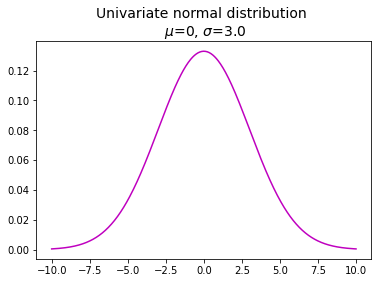

In [2]:
from scipy.stats import norm

# mean
mu = 0

#variance
var = 9

x = np.linspace(-10, 10, 500)
y = norm.pdf(x, mu, np.sqrt(var)) # equivalent to the equation above
plt.figure()
plt.plot(x, y, 'm-')
plt.title(f"Univariate normal distribution \n $\mu$={mu}, $\sigma$={np.sqrt(var)}")


**Multivariate case:**

$$
\mathcal{N} (\pmb{x} \mid \boldsymbol\mu, \boldsymbol\Sigma) 
= \frac{1}{(2\pi)^{D/2} |\boldsymbol\Sigma|^{1/2}}
\text{exp}[-\frac{1}{2} (\pmb{x} - \boldsymbol\mu)^T \boldsymbol\Sigma^{-1} (\pmb{x} - \boldsymbol\mu)]
$$

Where:
$D$ is the number of variates

$\boldsymbol\mu = \mathbb{E}[\pmb{x}] \in \mathbb{R}^D$ is the mean vector ($D \times 1$)

$\boldsymbol\Sigma = \text{Cov}[\pmb{x}] = \mathbb{E}[(\pmb{x} - \mathbb{E}[\pmb{x}])(\pmb{x} - \mathbb{E}[\pmb{x}])^T]$ is the covariance matrix($D \times D$)

$\boldsymbol\Sigma = 
\begin{pmatrix}
\sigma_1^2 & \text{Cov}[X_1, X_2] & \dots & \text{Cov}[X_1, X_D]\\
\text{Cov}[X_2, X_1] & \sigma_2^2 & \dots & \text{Cov}[X_2, X_D]\\
\vdots & \vdots & \ddots & \vdots\\
\text{Cov}[X_D, X_1] & \text{Cov}[X_D, X_2] & \dots & \sigma_D^2
\end{pmatrix}
$




**Bivariate case:** 

When $D$ = 2:

$\pmb{x} \in \mathbb{R}^2$ and $\boldsymbol\mu \in \mathbb{R}^2$

$\boldsymbol\Sigma = 
\begin{pmatrix}
\sigma_1^2 & \sigma_{12} \\
\sigma_{21} & \sigma_2^2
\end{pmatrix}
$





In [3]:
# some useful functions for bivariate normal distribution

from scipy.stats import multivariate_normal

# compute the bivariate Gaussian values for all pairs of x1 and x2 
def bivariate_gaussian(x1_range, x2_range, mu = np.zeros(2), sigma = np.eye(2)):
  xx1, xx2 = np.meshgrid(x1_range, x2_range)
  X = np.c_[xx1.ravel(), xx2.ravel()]
  y = multivariate_normal.pdf(X, mean=mu, cov=sigma) # equivalent to the equation above
  yy = y.reshape(xx1.shape)
  return (xx1, xx2, yy)

# plot the contours of a bivariate normal distribution
def plot_bg_contours(x1_range, x2_range, mu, sigma, **kwargs):
  xx1, xx2, yy = bivariate_gaussian(x1_range, x2_range, mu, sigma)
  plt.contour(xx1, xx2, yy, **kwargs)
  plt.axis('scaled')

Text(0.5, 0.92, '3D Projection')

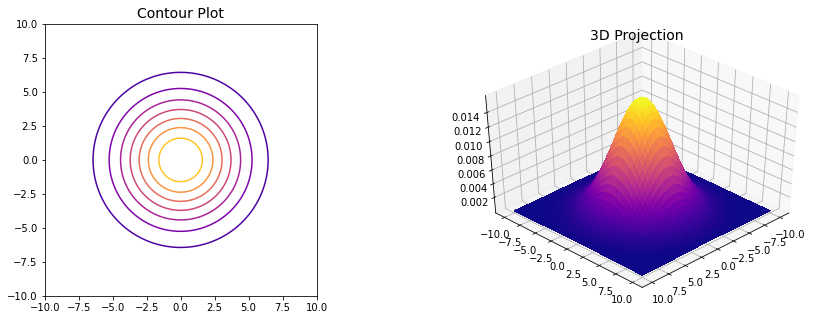

In [4]:
# mean vector (2 x 1)
mu = np.array([0, 0])

# Covariance matrix (2 x 2)
sigma = np.array([
    [10, 0],
    [0, 10]
])

# feature ranges
x1r = np.linspace(-10, 10, 200)
x2r = np.linspace(-10, 10, 200)

# Generate 2D and 3D plots
plt.figure(figsize=(15, 5))

# 2D contour plot
plt.subplot(1, 2, 1)
plot_bg_contours(x1r, x2r, mu=mu, sigma=sigma, cmap=plt.cm.plasma)
plt.title("Contour Plot")

# 3D surface plot
ax = plt.subplot(1, 2, 2, projection="3d")
xx1, xx2, yy = bivariate_gaussian(x1r, x2r, mu = mu, sigma = sigma)
ax.plot_surface(xx1, xx2, yy, cmap = plt.cm.plasma, antialiased=False)
ax.view_init(40, 45)
plt.title("3D Projection")

## Gaussian Discriminant Analysis (GDA)


$$
p(y = c \mid \pmb{x}; \boldsymbol{\theta}) = \frac
{p(\pmb{x} \mid y = c; \boldsymbol{\theta}) p(y = c; \boldsymbol{\theta})}
{\sum_{c'} p(\pmb{x} \mid y = c'; \boldsymbol{\theta}) p(y = c'; \boldsymbol{\theta})}
$$


In this notebook we focus on generative classifiers where the class conditional densities are multivariate Gaussian

$$
p(y = c \mid \pmb{x}; \boldsymbol{\theta}) = \mathcal{N} (\pmb{x} \mid \boldsymbol\mu_c, \boldsymbol\Sigma_c) 
$$

Therefore, the whole class posterior:

$$
p(y = c \mid \pmb{x}; \boldsymbol{\theta}) \propto \pi_c \mathcal{N} (\pmb{x} \mid \boldsymbol\mu_c, \boldsymbol\Sigma_c)
$$

Where $\pi_c = p(y = c; \boldsymbol{\theta})$ (prior probability of label c. (hence the $\pi$).

The posterior denominator can be ignored since it is just a normalization constant and is independent of $c$

### Make Synthetic Gaussian Data

In [5]:
# functions to generate and plot gaussian datasets

# get n_samples randomly from a bivariate Gaussian distribution
def bg_samples(n_samples, mu = np.zeros(2), sigma = np.eye(2), noise=False):
  X = np.random.multivariate_normal(mean=mu, cov=sigma, size=n_samples)
  # add some gaussian random noise
  if (noise):
    X += np.random.multivariate_normal(mean=mu, cov=sigma * 2, size=n_samples)  
  return X

# make bivariate Gaussian dataset
# n_samples: list of the number of samples for each class
# mus: list of 1x2 mean vectors for each class
# sigmas: list of 2x2 cov matrices for each class
# noise: will add random noise when True
def make_gaussian_data(n_samples, mus, sigmas, noise=False):
  n_classes = len(n_samples) # number of classes
  total_samples = np.array(n_samples).sum()
  X = bg_samples(n_samples[0], mus[0], sigmas[0], noise=noise)
  y = np.full((n_samples[0], 1), 0)
  for c in range(1, n_classes):
    X = np.vstack((X, bg_samples(n_samples[c], mus[c], sigmas[c], noise=noise)))
    y = np.vstack((y, np.full((n_samples[c], 1), c)))
  return X, y.reshape(-1)
     

# plot data points
def plot_dataset(X, y):
  # figure out the number of classes in the dataset
  n_classes = len(np.unique(y)) 
  markers = 'xod.svp*+D'
  for c in range(n_classes):
    plt.scatter(X[:, 0][y==c], X[:, 1][y==c], marker=markers[c])
  plt.xlabel("$x_1$")
  plt.ylabel("$x_2$", rotation=0)
  plt.axis("scaled")


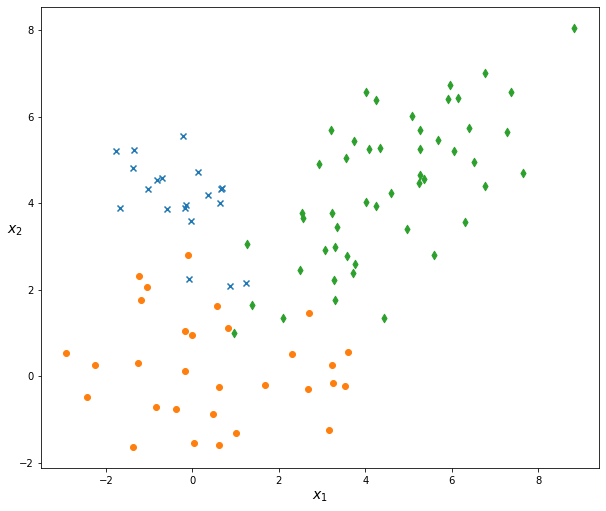

In [6]:
# dataset parameters

n_samples = [20, 30, 50]
#n_samples = [20000, 30000, 50000]

mus = [
    [0, 4],
    [0, 0],
    [4, 4]
]

sigmas = [
    np.eye(2),
    [[5, 0], [0, 2]],
    [[3, 2], [2, 3]]
]

X, y = make_gaussian_data(n_samples=n_samples, mus=mus, sigmas=sigmas)
plt.figure(figsize=(10, 10))
plot_dataset(X, y)

Text(0.5, 1.0, 'Ground truth, where we know $\\mu$s and $\\Sigma$s for every class')

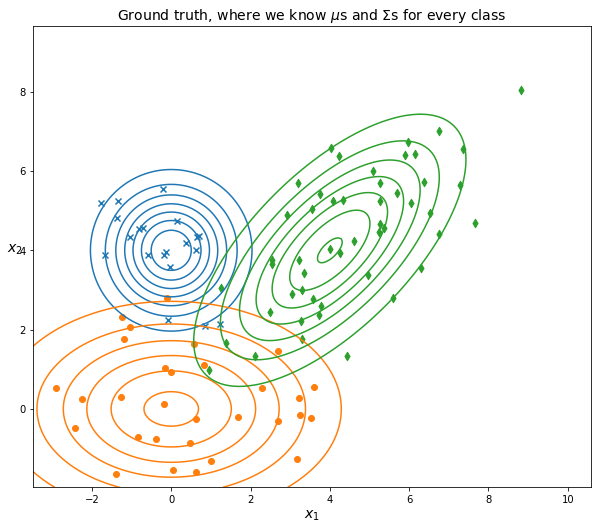

In [7]:
# superimpose the Gaussian contours over the data points

n_classes = len(n_samples)

# find the plotting ranges
X_mins = X.min(0) * 1.2
X_maxs = X.max(0) * 1.2
x1r = np.linspace(X_mins[0], X_maxs[0], 200)
x2r = np.linspace(X_mins[1], X_maxs[1], 200)

plt.figure(figsize=(10, 10))
plot_dataset(X, y)
for c in range(n_classes):
  plot_bg_contours(x1r, x2r, mu=mus[c], sigma=sigmas[c], colors=colors[c])

plt.title("Ground truth, where we know $\mu$s and $\Sigma$s for every class")


### Quadratic Decision Boundaries

The log posterior over class labels:

$$
\text{log} p(y = c\mid \pmb{x}; \boldsymbol{\theta}) = 
\text{log}\pi_c - \frac{1}{2}\text{log}|2\pi \boldsymbol{\Sigma_c}| -
\frac{1}{2}(\pmb{x} - \boldsymbol{\mu_c})^T \boldsymbol{\Sigma_c^{-1}} (\pmb{x} - \boldsymbol{\mu_c}) + 
\text{const}
$$

This **discriminant function** is **quadratic** in terms of $\pmb{x}$. Therefore, this is known as **quadratic discriminant analysis (QDA)**

The decision boundaries between the classes will be quadratic

#### **Model Fitting**

We find the model parameters using maximum likelihood estimation (MLE) on the training data

$\hat{\pi}_c = \frac{N_c}{N}$

$\boldsymbol{\hat{\mu}_c} = \frac{1}{N_c}\sum\limits_{n:y_n=c} \pmb{x}_n$

$\boldsymbol{\hat{\Sigma}_c} = \frac{1}{N_c} \sum\limits_{n:y_n=c}(\pmb{x}_n - \boldsymbol{\hat{\mu}_c})(\pmb{x}_n - \boldsymbol{\hat{\mu}_c})^T$


In [8]:
n_classes = np.unique(y).size # Number of clases/labels in the datasets
N = y.size # number of samples in the dataset

# Parameters fit using the MLE (equations above)
pi_hat = []
mus_hat = []
sigmas_hat = []

for c in range(n_classes):
  Nc = np.size(y[y==c])
  pi_hat.append(Nc / N)
  mus_hat.append(X[y==c].mean(0))
  D = (X[y==c] - mus_hat[c])
  sigmas_hat.append(np.dot(np.transpose(D), D) / Nc)

# Turn lists into numpy array
pi_hat = np.array(pi_hat)
mus_hat = np.array(mus_hat)
sigmas_hat = np.array(sigmas_hat)

# Compare the estimates with the ground truth
for c in range(n_classes):
  print(f"class({c}):")
  print(f"pi_{c} = {pi_hat[c]} \n Number of samples: {n_samples[c]}/{N}")
  print()
  print(f"mu_{c}_hat = {mus_hat[c]} \n mu_{c} = {mus[c]}")
  print()
  print("sigmas_hat =")
  for s in sigmas_hat[c]:
    print(s)
  print("sigmas =")
  for s in sigmas[c]:
    print(s)
  print('-----------------------------')



class(0):
pi_0 = 0.2 
 Number of samples: 20/100

mu_0_hat = [-0.26787228  4.07393322] 
 mu_0 = [0, 4]

sigmas_hat =
[ 0.72840645 -0.44249219]
[-0.44249219  0.88808497]
sigmas =
[1. 0.]
[0. 1.]
-----------------------------
class(1):
pi_1 = 0.3 
 Number of samples: 30/100

mu_1_hat = [0.49734789 0.21075549] 
 mu_1 = [0, 0]

sigmas_hat =
[ 3.41761488 -0.28474143]
[-0.28474143  1.384267  ]
sigmas =
[5, 0]
[0, 2]
-----------------------------
class(2):
pi_2 = 0.5 
 Number of samples: 50/100

mu_2_hat = [4.53501132 4.34726228] 
 mu_2 = [4, 4]

sigmas_hat =
[2.97685994 1.93488714]
[1.93488714 2.77300006]
sigmas =
[3, 2]
[2, 3]
-----------------------------


Text(0.5, 1.0, 'Estimated parameters')

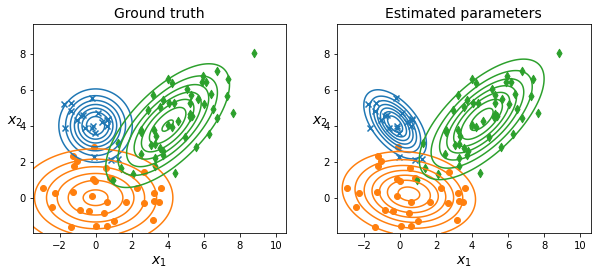

In [9]:
# superimpose the Gaussian contours over the data points

n_classes = len(n_samples)

# find the plotting ranges
X_mins = X.min(0) * 1.2
X_maxs = X.max(0) * 1.2
x1r = np.linspace(X_mins[0], X_maxs[0], 200)
x2r = np.linspace(X_mins[1], X_maxs[1], 200)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plot_dataset(X, y)
for c in range(n_classes):
  plot_bg_contours(x1r, x2r, mu=mus[c], sigma=sigmas[c], colors=colors[c])
plt.title("Ground truth")

plt.subplot(1, 2, 2)
plot_dataset(X, y)
for c in range(n_classes):
  plot_bg_contours(x1r, x2r, mu=mus_hat[c], sigma=sigmas_hat[c], colors=colors[c])
plt.title("Estimated parameters")


The MLE for $\hat{\boldsymbol{\Sigma}}_c$ can overfit when $N_c$ is small compared to the dimensionality of the input features. A solution is to tie the covariance matricies so they are shared among all classes (Linear decision boundary) we will see this shortly. Even more restricting is making the tied covariance matrix diagonal (i.e. no correlation between features) this is called Naive Bayes assumption as we will see.

#### Computing the log of posterior proababilities

We compute the log probability for each class:

$$
\text{log} p(y = c\mid \pmb{x}; \boldsymbol{\theta}) = 
\text{log}\pi_c - \frac{1}{2}\text{log}|2\pi \boldsymbol{\Sigma_c}| -
\frac{1}{2}(\pmb{x} - \boldsymbol{\mu_c})^T \boldsymbol{\Sigma_c^{-1}} (\pmb{x} - \boldsymbol{\mu_c}) + 
\text{const}
$$

Note that $log$ is the natural logarithm

In [10]:
# compute the log probability for a single data point x
def log_proba(x, mu, sigma, prior):
  return np.log(prior) - (1/2) * np.log(2 * np.pi * np.linalg.det(sigma)) - (1/2) * ((x - mu) @ np.linalg.inv(sigma) @ (x - mu).reshape(-1, 1))


You can compute the log probability for each class and predict the class using the higher value. Change `i` in the code block below to test different data points

In [11]:
# index of data point
i = 50

x = X[i]
l = y[i]

print("data point:",x)
print("actual class: ", l)

for c in range(n_classes):
  print(f"class {c} log proba: {log_proba(x, mus_hat[c], sigmas_hat[c], pi_hat[c])}")

data point: [3.57473599 2.76762672]
actual class:  2
class 0 log proba: [-13.11914232]
class 1 log proba: [-7.18540888]
class 2 log proba: [-2.82146013]


We can also plot the decision boundaries and regions

In [12]:
def plot_boundaries(mus, sigmas, priors, axes):
  n_classes = mus.shape[0]
  x1r = np.linspace(axes[0], axes[1], 200)
  x2r = np.linspace(axes[2], axes[3], 200)
  x1, x2 = np.meshgrid(x1r, x2r)
  X = np.c_[x1.ravel(), x2.ravel()]
  labels = []
  for x in X:
    l = []
    for c in range(n_classes):
      l.append(log_proba(x, mus[c], sigmas[c], priors[c]))
    labels.append(np.array(l).reshape(-1,))
  labels = np.array(labels)
  predictions = labels.argmax(1).reshape(x1.shape)
  plt.contourf(x1, x2, predictions, alpha=0.2)
  
  


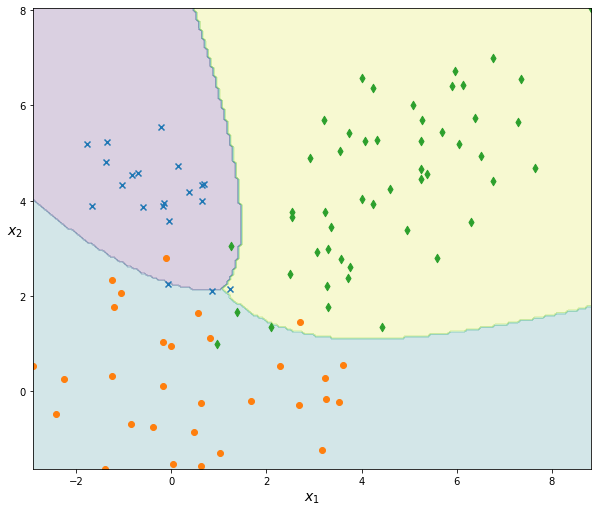

In [13]:
plt.figure(figsize=(10, 10))
plot_boundaries(mus_hat, sigmas_hat, pi_hat, [X.min(0)[0], X.max(0)[0], X.min(0)[1], X.max(0)[1]])
plot_dataset(X, y)


#### **Model Fitting using `sklearn`**

Scikit Learn makes things much easier. Let's see how we can achieve the same results above with much simpler code.

The [QuadraticDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis) model can be used to obtain similar results

In [14]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
clf = QDA(store_covariance=True)
clf.fit(X, y)


QuadraticDiscriminantAnalysis(store_covariance=True)

In [15]:
clf.get_params()

{'priors': None, 'reg_param': 0.0, 'store_covariance': True, 'tol': 0.0001}

In [16]:
clf.priors_

array([0.2, 0.3, 0.5])

In [17]:
pi_hat # estimated manually

array([0.2, 0.3, 0.5])

In [18]:
clf.means_

array([[-0.26787228,  4.07393322],
       [ 0.49734789,  0.21075549],
       [ 4.53501132,  4.34726228]])

In [19]:
mus_hat # estimated manually

array([[-0.26787228,  4.07393322],
       [ 0.49734789,  0.21075549],
       [ 4.53501132,  4.34726228]])

In [20]:
clf.covariance_

[array([[ 0.76674364, -0.46578126],
        [-0.46578126,  0.93482628]]), array([[ 3.53546367, -0.2945601 ],
        [-0.2945601 ,  1.43200034]]), array([[3.03761218, 1.97437463],
        [1.97437463, 2.8295919 ]])]

In [21]:
sigmas_hat # estimated manually

array([[[ 0.72840645, -0.44249219],
        [-0.44249219,  0.88808497]],

       [[ 3.41761488, -0.28474143],
        [-0.28474143,  1.384267  ]],

       [[ 2.97685994,  1.93488714],
        [ 1.93488714,  2.77300006]]])

Prediction, prediction probability, prediction log probability, and decision function

In [22]:
# index of data point
i = 75

x = X[i].reshape(1, -1)
l = y[i]

print("data point:",x)
print("actual class: ", l)

print("prediction: ", clf.predict(x))
print("prediction probability: ", clf.predict_proba(x))
print("prediction log probability: ", clf.predict_log_proba(x))
print("decision function: ", clf.decision_function(x))

data point: [[4.01144817 4.02284887]]
actual class:  2
prediction:  [2]
prediction probability:  [[5.73169305e-08 2.67301683e-04 9.99732641e-01]]
prediction log probability:  [[-1.66746698e+01 -8.22713264e+00 -2.67394746e-04]]
decision function:  [[-18.18621899  -9.73868185  -1.5118166 ]]


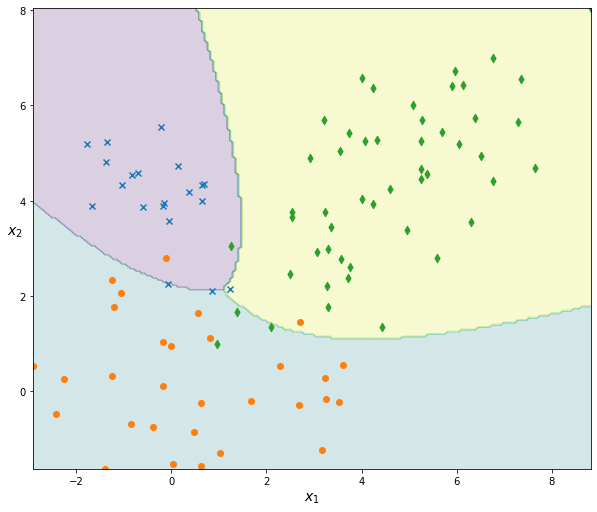

In [23]:
def plot_prediction(clf, axes):
  x1r = np.linspace(axes[0], axes[1], 200)
  x2r = np.linspace(axes[2], axes[3], 200)
  x1, x2 = np.meshgrid(x1r, x2r)
  X = np.c_[x1.ravel(), x2.ravel()]
  y_pred = clf.predict(X).reshape(x1.shape)
  plt.contourf(x1, x2, y_pred, alpha=0.2)

plt.figure(figsize=(10, 10))
plot_prediction(clf, [X.min(0)[0], X.max(0)[0], X.min(0)[1], X.max(0)[1]])
plot_dataset(X, y)

### Linear Decision Boundaries

We get linear decision boundaries if we let the means vector $\boldsymbol{\mu}_c$ vary with each class but **tied** or **shared** the covariance matrices between the different classes $\boldsymbol{\Sigma}_c = \boldsymbol{\Sigma}$ (in other words $\boldsymbol{\Sigma}$ is independent of the class $c$)

The log posterior over class labels:

$$
\text{log} p(y = c\mid \pmb{x}; \boldsymbol{\theta}) = 
\text{log}\pi_c - \frac{1}{2}(\pmb{x} - \boldsymbol{\mu_c})^T \boldsymbol{\Sigma^{-1}} (\pmb{x} - \boldsymbol{\mu_c}) + 
\text{const}
$$

This is of the form 

$$
\text{log} p(y = c\mid \pmb{x}; \boldsymbol{\theta}) = \gamma_c + \pmb{x}^T \beta_c + \mathcal{k}
$$

This **discriminant function** is **linear** in terms of $\pmb{x}$. Therefore, this is known as **linear discriminant analysis (LDA)**

**Model fitting for tied covariances**

We find the model parameters using maximum likelihood estimation (MLE) on the training data

$\hat{\pi}_c = \frac{N_c}{N}$

$\boldsymbol{\hat{\mu}_c} = \frac{1}{N_c}\sum\limits_{n:y_n=c} \pmb{x}_n$

$\boldsymbol{\hat{\Sigma}} = \frac{1}{N} \sum\limits_{c=1}^{C}\sum\limits_{n:y_n=c}(\pmb{x}_n - \boldsymbol{\hat{\mu}_c})(\pmb{x}_n - \boldsymbol{\hat{\mu}_c})^T$

The estimate of $\boldsymbol{\hat{\Sigma}}$ is more relaiable than in the quadratic case since we are pooling all samples across all classes

We will use [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis) from sklearn to fit this model and plot its decision boundaries

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
clf = LDA(store_covariance=True)
clf.fit(X, y)

LinearDiscriminantAnalysis(store_covariance=True)

In [25]:
clf.covariance_

array([[2.65939572, 0.7935227 ],
       [0.7935227 , 1.97939712]])

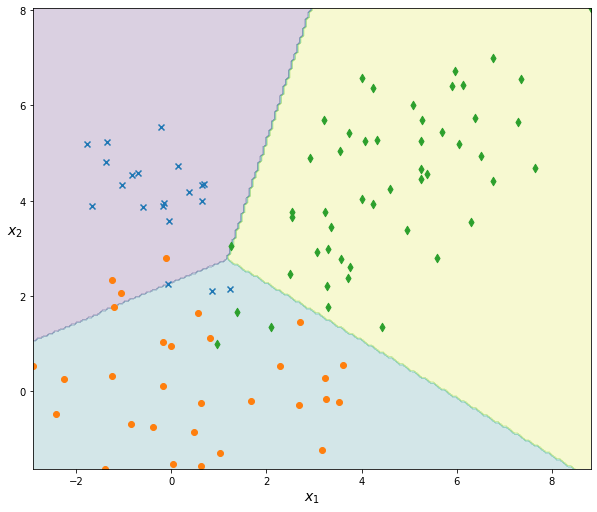

In [26]:
plt.figure(figsize=(10, 10))
plot_prediction(clf, [X.min(0)[0], X.max(0)[0], X.min(0)[1], X.max(0)[1]])
plot_dataset(X, y)